In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd '/content/drive/MyDrive/Project_682'

Mounted at /content/drive/
/content/drive/MyDrive/Project_682


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Loading and Cleaning Metadata

In [ ]:
df = pd.read_csv('HAM10000_metadata.csv')

In [ ]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [ ]:
df.shape

(10015, 8)

In [ ]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dataset          object
dtype: object

In [ ]:
df.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
count,10015,10015,10015,10015,9958.000000,10015,10015,10015
unique,7470,10015,7,4,NaN,3,15,4
top,HAM_0003789,ISIC_0034231,nv,histo,NaN,male,back,vidir_molemax
freq,6,1,6705,5340,NaN,5406,2192,3954
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [ ]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dataset          0
dtype: int64

In [ ]:
mean = int(df['age'].mean())
df['age'].fillna(mean,inplace=True)

In [ ]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dataset         0
dtype: int64

In [ ]:
lesion_type = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['lesion_type'] = df['dx'].map(lesion_type.get) 
df['lesion_type_idx'] = pd.Categorical(df['lesion_type']).codes

In [ ]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
imageid_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('', '*', '*.jpg'))}

In [ ]:
df['path'] = df['image_id'].map(imageid_path.get)

In [ ]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,lesion_type,lesion_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2,HAM10000/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2,HAM10000/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2,HAM10000/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions,2,HAM10000/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,Benign keratosis-like lesions,2,HAM10000/ISIC_0031633.jpg
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratoses,0,HAM10000/ISIC_0033084.jpg
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratoses,0,HAM10000/ISIC_0033550.jpg
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratoses,0,HAM10000/ISIC_0033536.jpg
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,Actinic keratoses,0,HAM10000/ISIC_0032854.jpg


In [ ]:
df['lesion_type_idx'].value_counts()

4    6705
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: lesion_type_idx, dtype: int64

## Denoise, Resize and Data Augmentation

In [ ]:
import cv2
from cv2 import imread, resize

In [ ]:
def produce_new_img(img2):
    imga = cv2.rotate(img2,cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2,cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2,cv2.ROTATE_180)
    imgd = cv2.flip(img2,0)
    imge = cv2.flip(img2,1)
    return imga,imgb,imgc,imgd,imge

X = []
y = []

kernel = cv2.getStructuringElement(1,(17,17)) # Kernel for the morphological filtering

for i in range(len(df)):
  src = cv2.imread(df['path'][i])
  grayScale = cv2.cvtColor( src, cv2.COLOR_RGB2GRAY ) #1 Convert the original image to grayscale
  blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel) #2 Perform the blackHat filtering on the grayscale image to find the hair countours
  ret,thresh2 = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY) # intensify the hair countours in preparation for the inpainting algorithm
  dst = cv2.inpaint(src,thresh2,1,cv2.INPAINT_TELEA) # inpaint the original image depending on the mask

  file_to_read = df['path'][i]
  img = imread(file_to_read)
  img2 = resize(dst,(50,50))
  X.append(img2)
    
  #targets
  output = df['lesion_type_idx'][i]
  y.append(output)
    
  # add more images for class between 1-6, rotating them 
  if output != 4:
    new_img = produce_new_img(img2)
    for i in range(5):
      X.append(new_img[i])
      y.append(output)

In [ ]:
print(y.count(0),y.count(1),y.count(2),y.count(3),y.count(4),y.count(5),y.count(6))

1962 3084 6594 690 6705 6678 852


## Saving data after pre-processing

In [ ]:
import pickle

In [ ]:
file_name = "X.pkl"

#open_file = open(file_name, "wb")
#pickle.dump(X, open_file)
#open_file.close()

open_file = open(file_name, "rb")
X = pickle.load(open_file)
open_file.close()

#print(X)

In [ ]:
X= np.array(X)

In [ ]:
X.shape

In [ ]:
X = X.astype(np.float64)

In [ ]:
X.dtype

In [ ]:
file_name = "y.pkl"

#open_file = open(file_name, "wb")
#pickle.dump(y, open_file)
#open_file.close()

open_file = open(file_name, "rb")
y = pickle.load(open_file)
open_file.close()

#print(y)

In [ ]:
y = np.array(y)

In [ ]:
y.shape

In [ ]:
from keras.utils.np_utils import to_categorical

X = np.array(X)
y = np.array(y)

#y_train = to_categorical(y, num_classes=7)

In [ ]:
X = X.astype(np.float64)

In [ ]:
#y_train = [1 if each == 5 else 0 for each in y]

## Train and Test split

In [ ]:
from sklearn.model_selection import train_test_split

# split in 70% training and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


print('Train dataset shape',X_train.shape)
print('Test dataset shape',X_test.shape)

Train dataset shape (21252, 50, 50, 3)
Test dataset shape (5313, 50, 50, 3)


## SVM

In [ ]:
# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 20000
num_validation = 1252
num_test = 5313
num_dev = 252

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (20000, 50, 50, 3)
Train labels shape:  (20000,)
Validation data shape:  (1252, 50, 50, 3)
Validation labels shape:  (1252,)
Test data shape:  (5313, 50, 50, 3)
Test labels shape:  (5313,)


In [ ]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (20000, 7500)
Validation data shape:  (1252, 7500)
Test data shape:  (5313, 7500)
dev data shape:  (252, 7500)


[130.5766  122.6324  160.91665 134.3819  126.2479  165.0601  137.9716
 129.64785 168.9681  141.50885]


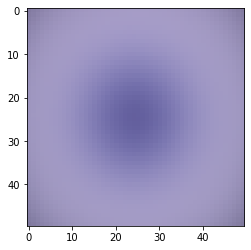

In [ ]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((50,50,3)).astype('uint8')) # visualize the mean image
plt.show()

In [ ]:
# second: subtract the mean image from train and test data
X_train = X_train -  mean_image
X_val = X_val -  mean_image
X_test = X_test - mean_image
X_dev = X_dev - mean_image

In [ ]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(20000, 7501) (1252, 7501) (5313, 7501) (252, 7501)


In [ ]:
import numpy as np
from random import shuffle

def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  dW = np.zeros(W.shape) # initialize the gradient as zero

  # compute the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  for i in range(num_train):
    scores = X[i].dot(W)
    correct_class_score = scores[y[i]]
    for j in range(num_classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1 # note delta = 1
      if margin > 0:
        dW[:,j] = dW[:,j] + X[i]
        dW[:,y[i]] = dW[:,y[i]] -X[i]
        loss += margin

  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
  loss /= num_train
  dW /= num_train

  # Add regularization to the loss.
  loss += reg * np.sum(W * W)
  dW += reg * 2 * W

  #############################################################################
  # TODO:                                                                     #
  # Compute the gradient of the loss function and store it dW.                #
  # Rather that first computing the loss and then computing the derivative,   #
  # it may be simpler to compute the derivative at the same time that the     #
  # loss is being computed. As a result you may need to modify some of the    #
  # code above to compute the gradient.                                       #
  #############################################################################


  return loss, dW


def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation.

  Inputs and outputs are the same as svm_loss_naive.
  """
  loss = 0.0
  dW = np.zeros(W.shape) # initialize the gradient as zero

  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the structured SVM loss, storing the    #
  # result in loss.                                                           #
  #############################################################################
  num_train = X.shape[0]

  scores = X.dot(W)
  #print(scores.shape)
  correct_class_score_y = scores[np.arange(num_train), y]
  #print(correct_class_score_y.shape)
  l = scores - correct_class_score_y[:,None] + 1
  #print(l.shape)
  #print(l)
  l[np.arange(num_train), y] -=1
  l_max = np.maximum(0, l)
  #print(l_max.shape)
  #print(l_max)
  Final_l = np.sum(l_max)

  loss = (Final_l/num_train)
  #print(loss)

  # Add regularization to the loss.
  loss += reg * np.sum(W * W) 

  pass
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################


  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the gradient for the structured SVM     #
  # loss, storing the result in dW.                                           #
  #                                                                           #
  # Hint: Instead of computing the gradient from scratch, it may be easier    #
  # to reuse some of the intermediate values that you used to compute the     #
  # loss.                                                                     #
  #############################################################################

  mask = np.zeros(l_max.shape)
  #print(mask.shape)
  case = l_max>0
  mask[case] = 1
  mask_sum = np.sum(mask, axis=1)
  #print(mask_sum.shape)
  mask[np.arange(num_train), y] = -mask_sum
  #print(mask.shape)
  dW = np.dot(X.T, mask)

  # Average
  dW /= num_train

  # Regularize
  dW += reg * 2 * W
  pass
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return loss, dW


In [ ]:
import numpy as np
from random import shuffle

def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops)

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using explicit loops.     #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  # compute the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  
  for i in range(num_train):
    scores = X[i].dot(W)
    correct_class_score = scores[y[i]]
    exp= np.exp(scores)
    sum_exp = np.sum(exp)
    log_sum_exp = np.log(sum_exp)
    loss += (-correct_class_score + log_sum_exp)
  
    for j in range(num_classes):
      softmax_function = np.exp(scores[j]) / sum_exp
      if j == y[i]:
        dW[:,j] = dW[:,j] + ((-1 + softmax_function) *X[i]) 
      else: 
        dW[:,j] = dW[:,j] + softmax_function *X[i] 

  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
  loss /= num_train
  dW /= num_train

  # Add regularization to the loss.
  loss += reg * np.sum(W * W)
  dW += reg * 2 * W

  pass
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW


def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  num_train = X.shape[0]
  scores = X.dot(W)
  #print(scores.shape)
  correct_class_score_y = scores[np.arange(num_train), y]
  #print(correct_class_score_y.shape)
  sum_correct_class_score_y = np.sum(-correct_class_score_y)
  #print(sum_correct_class_score_y)
  exp= np.exp(scores)
  sum_exp = np.sum(exp, axis=1)
  log_sum_exp = np.log(sum_exp)
  Final_l = sum_correct_class_score_y + np.sum(log_sum_exp)

  #Gradient
  #print(exp.shape)
  #print(sum_exp.shape)
  Grad = exp / sum_exp[:,None]
  #print(Grad.shape)
  Grad[np.arange(num_train),y] -=1
  dW = X.T.dot(Grad)

  loss = (Final_l/num_train)
  dW /= num_train
  #print(loss)

  # Add regularization to the loss.
  loss += reg * np.sum(W * W)
  dW += reg * 2 * W
  pass
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW



In [ ]:
from __future__ import print_function

import numpy as np

class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO:                                                                 #
      # Sample batch_size elements from the training data and their           #
      # corresponding labels to use in this round of gradient descent.        #
      # Store the data in X_batch and their corresponding labels in           #
      # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
      # and y_batch should have shape (batch_size,)                           #
      #                                                                       #
      # Hint: Use np.random.choice to generate indices. Sampling with         #
      # replacement is faster than sampling without replacement.              #
      #########################################################################
      sampling_indices = np.random.choice(num_train,batch_size)
      #print(sampling_indices.shape)
      X_batch = X[sampling_indices]
      #print(X_batch.shape)
      y_batch = y[sampling_indices]
      #print(y_batch.shape)
      pass
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      # perform parameter update
      #########################################################################
      # TODO:                                                                 #
      # Update the weights using the gradient and the learning rate.          #
      #########################################################################
      self.W = self.W - learning_rate * grad
      pass
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################
    #print(y_pred.shape)
    #print(self.W.shape)
    scores = X.dot(self.W)
    #print(scores.shape) 
    max_scores = np.argmax(scores, axis=1)
    #print(max_scores.shape)
    y_pred = max_scores
    pass
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred

  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative.
    Subclasses will override this.

    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass


class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch, reg):
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)
    #return svm_loss_naive(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)


In [ ]:
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(7501, 7) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 5.732113


In [ ]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 1335.602757
iteration 100 / 1500: loss 487.811415
iteration 200 / 1500: loss 180.974047
iteration 300 / 1500: loss 68.114237
iteration 400 / 1500: loss 26.901948
iteration 500 / 1500: loss 12.164379
iteration 600 / 1500: loss 6.939884
iteration 700 / 1500: loss 4.731552
iteration 800 / 1500: loss 4.065711
iteration 900 / 1500: loss 3.644685
iteration 1000 / 1500: loss 3.310620
iteration 1100 / 1500: loss 3.540954
iteration 1200 / 1500: loss 3.678685
iteration 1300 / 1500: loss 3.445148
iteration 1400 / 1500: loss 3.568559
That took 23.007956s


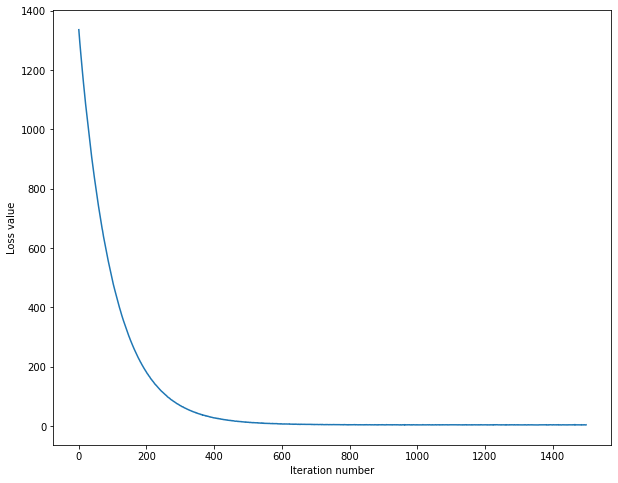

In [ ]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.493150
validation accuracy: 0.498403


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-8, 1e-7, 1e-6]
regularization_strengths = [1e3, 2e3, 3e3, 1e4, 2e4, 3e4, 1e5]
#learning_rates = [1e-7, 1e-6, 5e-5]
#regularization_strengths = [1e4, 2e4, 2.3e4, 2.5e4, 3e4, 4e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# Your code
for lr in learning_rates:
  for rs in regularization_strengths: 
    svm = LinearSVM()
    loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=rs,
                          num_iters=2500, verbose=True)
    y_train_pred = svm.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred) 
    #print('training accuracy: ', training_accuracy)
    y_val_pred = svm.predict(X_val)
    validation_accuracy = np.mean(y_val == y_val_pred)
    #print('validation accuracy: ', validation_accuracy)

    # Storing in results dictionary
    results[(lr,rs)] = (training_accuracy,validation_accuracy)

    if(validation_accuracy>best_val):
      best_val = validation_accuracy
      best_svm = svm
      best_y_val_pred = y_val_pred

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2500: loss 68.160685
iteration 100 / 2500: loss 62.245520
iteration 200 / 2500: loss 61.098470
iteration 300 / 2500: loss 60.436813
iteration 400 / 2500: loss 60.696606
iteration 500 / 2500: loss 58.390902
iteration 600 / 2500: loss 57.772809
iteration 700 / 2500: loss 57.858567
iteration 800 / 2500: loss 55.845976
iteration 900 / 2500: loss 56.978609
iteration 1000 / 2500: loss 55.647923
iteration 1100 / 2500: loss 55.503221
iteration 1200 / 2500: loss 55.426523
iteration 1300 / 2500: loss 54.930076
iteration 1400 / 2500: loss 55.170483
iteration 1500 / 2500: loss 53.987507
iteration 1600 / 2500: loss 54.328528
iteration 1700 / 2500: loss 54.046825
iteration 1800 / 2500: loss 53.953235
iteration 1900 / 2500: loss 53.587913
iteration 2000 / 2500: loss 53.544879
iteration 2100 / 2500: loss 53.563605
iteration 2200 / 2500: loss 52.850357
iteration 2300 / 2500: loss 53.302781
iteration 2400 / 2500: loss 53.105423
iteration 0 / 2500: loss 117.044967
iteration 100 / 2500: loss

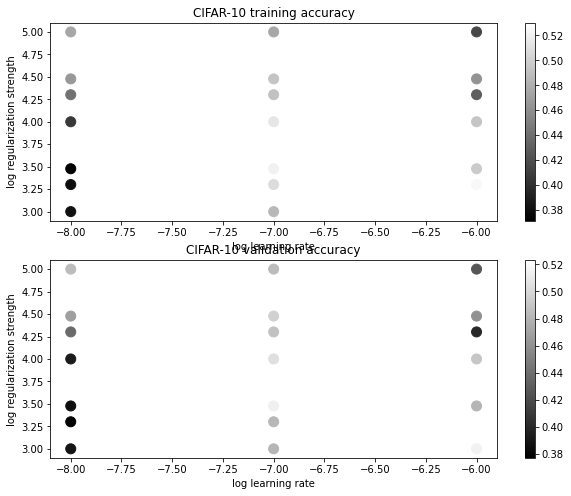

In [ ]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.514022
